# LLM Knowledge Distillation

### Objective:
Train a smaller model using larger model via **Knowledge Distillation** and **Reinforcement Learning**

#### *NOTE:*
Using **GPT-2 Medium** to **GPT-2** in the below example due of computational constraints 😞

The below example is entirely for demonstration purpose.

This code has been executed on **NVIDIA T4** GPU.

## Imports & Configuration

We start by importing all libraries we need:

1. **torch** for PyTorch (core tensors and automatic differentiation).
2. **torch.nn.functional** for convenience functions (like `kl_div`, `log_softmax`).
3. **transformers** from Hugging Face, which gives us:
   - `AutoTokenizer`, `AutoModelForCausalLM`: to load GPT-2–style models.
   - `Trainer`, `TrainingArguments`: high-level training utilities.
4. **datasets** from Hugging Face to load WikiText-2.
5. **matplotlib** and **numpy** for plotting and numerical operations.
6. **tqdm** for progress bars.

We also define a `Config` class to store hyperparameters:
- **Teacher** = `gpt2-medium` (~345M parameters, smaller than gpt2-large).
- **Student** = `gpt2` (~124M parameters).
- **MAX_LENGTH** = 128 tokens.
- **ALPHA** ($\alpha$) and **TEMP** ($\tau$) for **distillation**.
- **Batch sizes** and **epochs** (we keep them small in this demo).
- PPO parameters (e.g., how many tokens to generate).

Finally, we set the `device` to `"cuda"` if available. Otherwise, use CPU.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
class Config:
    TEACHER = "gpt2-medium"  # smaller teacher model than gpt2-large
    STUDENT = "gpt2"         # student model
    MAX_LENGTH = 128

    # Distillation hyperparameters
    ALPHA = 0.7    # (1 - alpha) * CE + alpha * KL
    TEMP = 2.0     # Temperature scaling factor

    # Trainer hyperparameters
    EPOCHS = 10               # for demonstration, 10 epoch
    BATCH_SIZE = 2           # reduce if out of memory (OOM)
    LOGGING_STEPS = 10

    # PPO
    PPO_EPOCHS = 10
    PPO_MAX_NEW_TOKENS = 50

## Dataset Loading and Preparation

We define a function `load_and_prepare_data()` that:
1. Loads the WikiText-2 **raw** dataset (the "train" split).
2. Filters out lines with fewer than 100 characters for minimal length.
3. Splits the filtered dataset into **train** (90%) and **validation** (10%).
4. Optionally subsets the dataset to make it smaller (to fit in memory).
5. Creates a **tokenizer** (from the teacher model). We set `pad_token = eos_token` for GPT-2.
6. Defines a `tokenize_fn` function to truncate/pad examples to `MAX_LENGTH`.
7. Applies the tokenizer to train/validation sets, then sets `"labels" = "input_ids"` for language modeling.
8. Removes the `"text"` column and sets the dataset format to `torch`.

Return values:  
- `train_tokenized`, `val_tokenized`, and `tokenizer`.

In [4]:
def load_and_prepare_data():
    """
    Load and split Wikitext-2 into train/val, tokenize, format for LM tasks.
    """
    # Load raw dataset
    raw_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

    # Filter out short lines (< 100 characters)
    raw_dataset = raw_dataset.filter(lambda x: len(x["text"]) > 100)

    # Train/validation split (90/10)
    split_ds = raw_dataset.train_test_split(test_size=0.1, seed=42)
    train_raw = split_ds["train"]
    val_raw   = split_ds["test"]

    # subset for demo (reduce memory usage)
    train_raw = train_raw.select(range(min(len(train_raw), 1000)))
    val_raw   = val_raw.select(range(min(len(val_raw), 200)))

    # Create tokenizer (use teacher's tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(Config.TEACHER)
    tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad_token by default

    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=Config.MAX_LENGTH
        )

    # Tokenize train and val sets
    train_tokenized = train_raw.map(tokenize_fn, batched=True)
    val_tokenized   = val_raw.map(tokenize_fn,   batched=True)

    # Set "labels" = "input_ids"
    def set_labels(example):
        example["labels"] = example["input_ids"].copy()
        return example

    train_tokenized = train_tokenized.map(set_labels)
    val_tokenized   = val_tokenized.map(set_labels)

    # Remove raw "text" column
    train_tokenized = train_tokenized.remove_columns(["text"])
    val_tokenized   = val_tokenized.remove_columns(["text"])

    # Convert to PyTorch format
    train_tokenized.set_format(type="torch")
    val_tokenized.set_format(type="torch")

    return train_tokenized, val_tokenized, tokenizer

## Distillation Trainer Class

We define `DistillationTrainer` by subclassing Hugging Face’s `Trainer`. We override `compute_loss` to include:

$$
\text{Loss} = (1 - \alpha) \cdot \mathcal{L}_{CE} \,+\, \alpha \cdot \mathcal{L}_{KL},
$$
where:
- $\mathcal{L}_{CE}$ is the standard student cross-entropy loss
- $\mathcal{L}_{KL}$ is the KL-divergence between teacher and student logits:
  $$
  \mathcal{L}_{KL} = D_{KL}(S \| T)
                    = \sum_{i} S_i \log\Bigl(\frac{S_i}{T_i}\Bigr),
  $$
  with **temperature scaling**:
  $$
  S_i = \text{softmax}\Bigl(\frac{z^S_i}{\tau}\Bigr),
  \quad
  T_i = \text{softmax}\Bigl(\frac{z^T_i}{\tau}\Bigr).
  $$
  
We add a `**kwargs` in `compute_loss` to avoid errors if the `Trainer` passes extra arguments (like `num_items_in_batch`).


In [5]:
class DistillationTrainer(Trainer):
    def __init__(self, teacher, alpha, temp, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher
        self.alpha = alpha
        self.temp = temp

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Combine:
          - CE loss from student's outputs
          - KL divergence between student & teacher
        """
        # Student forward pass
        outputs_student = model(**inputs)
        student_loss_ce = outputs_student.loss        # scalar cross-entropy
        student_logits = outputs_student.logits / self.temp

        # Teacher forward pass (no grad)
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)
            teacher_logits = outputs_teacher.logits / self.temp

        # KL divergence
        loss_kl = F.kl_div(
            F.log_softmax(student_logits, dim=-1),
            F.softmax(teacher_logits, dim=-1),
            reduction="batchmean"
        ) * (self.temp ** 2)

        # Combined loss
        loss = (1 - self.alpha) * student_loss_ce + self.alpha * loss_kl

        return (loss, outputs_student) if return_outputs else loss

## Distillation Training Function

`run_distillation` handles setting up:
1. **TrainingArguments** (e.g., batch size, number of epochs).
2. Instantiating `DistillationTrainer`.
3. Actually running `.train()` on the `train_data`.
4. Optionally evaluating on the `val_data`.

We then return the `trainer` object for further inspection or usage.

In [6]:
def run_distillation(teacher, student, train_data, val_data, tokenizer):
    """
    Configures training arguments and runs distillation using our DistillationTrainer.
    """
    training_args = TrainingArguments(
        output_dir="./results",
        overwrite_output_dir=True,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        num_train_epochs=Config.EPOCHS,
        logging_steps=Config.LOGGING_STEPS,
        evaluation_strategy="epoch",   # evaluate at each epoch end
        save_strategy="no",
        fp16=False,                    # set True if you want half precision
        report_to="none"
    )

    trainer = DistillationTrainer(
        teacher=teacher,
        alpha=Config.ALPHA,
        temp=Config.TEMP,
        model=student,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
    )
    trainer.train()

    # Evaluate on validation set after training
    eval_metrics = trainer.evaluate()
    print("[Distillation] Validation metrics:", eval_metrics)

    return trainer

## Perplexity Evaluation

We define a custom function, `evaluate_perplexity`, to calculate perplexity on a given dataset.  
Perplexity for a language model is:

$$
\mathrm{PPL} = \exp\Bigl(\text{average cross-entropy loss}\Bigr).
$$

Implementation details:
1. Switch the model to `eval()` mode.
2. Loop through the dataset in small batches.
3. Accumulate the scalar cross-entropy loss.
4. Exponentiate the mean to get perplexity.

In [7]:
def evaluate_perplexity(model, dataset, tokenizer):
    """
    Compute perplexity by going through data in small batches,
    summing cross-entropy, then exponentiating the average.
    """
    model.eval()
    total_loss = 0
    total_batches = 0
    batch_size = Config.BATCH_SIZE

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
        loss_val = outputs.loss.item()
        total_loss += loss_val
        total_batches += 1

    avg_loss = total_loss / total_batches
    ppl = np.exp(avg_loss)
    return ppl

## Simple PPO

We define a very simplified PPO trainer (`PPOTrainerCustom`):
1. For each prompt, we generate text from both student and teacher.
2. We define a `compute_reward` function that compares the average embeddings of the generated tokens (student vs. teacher) using cosine similarity.
3. The loss is `-(log_prob_of_student_final_token * reward)`.
   - This is just a naive example of policy gradient, not full PPO with clipping or advantage estimation.

This “fine-tuning” step can be used after knowledge distillation if we want to align the student with the teacher in a more RL-based manner.

In [8]:
class PPOTrainerCustom:
    def __init__(self, student, teacher, tokenizer, device):
        """
        student: GPT-2 (hidden size 768)
        teacher: GPT-2 medium (hidden size 1024)
        tokenizer: shared tokenizer
        device: 'cuda' or 'cpu'
        """
        self.student = student
        self.teacher = teacher
        self.tokenizer = tokenizer
        self.device = device

        # Because teacher has hidden_dim=1024 and student has hidden_dim=768,
        # we define a linear projection that maps teacher embeddings -> 768.
        self.teacher_proj = nn.Linear(1024, 768, bias=False).to(self.device)

    def compute_reward(self, student_gen, teacher_gen):
        """
        Project teacher embeddings from 1024 to 768,
        then compute average-pool embeddings and do cosine similarity.
        """
        with torch.no_grad():
            # Student embeddings: shape [batch, seq_len, 768]
            student_emb = self.student.transformer.wte(student_gen)
            # Teacher embeddings: shape [batch, seq_len, 1024]
            teacher_emb = self.teacher.transformer.wte(teacher_gen)

        # Project teacher's [batch, seq_len, 1024] -> [batch, seq_len, 768]
        teacher_emb_768 = self.teacher_proj(teacher_emb)

        # Average along seq_len dimension
        student_mean = student_emb.mean(dim=1)      # [batch, 768]
        teacher_mean = teacher_emb_768.mean(dim=1)  # [batch, 768]

        # Cosine similarity -> scalar
        reward = F.cosine_similarity(student_mean, teacher_mean, dim=-1).mean()
        return reward

    def train(self, prompts, epochs=1):
        """
        Extremely simplified PPO loop:
         1. Generate from student & teacher
         2. Compute reward by comparing embeddings
         3. Negative log prob of student's final token * reward
        """
        optimizer = torch.optim.AdamW(self.student.parameters(), lr=5e-5)
        all_losses = []

        # Student in train mode; teacher in eval mode
        self.student.train()
        self.teacher.eval()

        for _ in range(epochs):
            for prompt in prompts:
                # 1. Tokenize prompt
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

                # 2. Student generation
                student_gen = self.student.generate(
                    **inputs,
                    max_new_tokens=Config.PPO_MAX_NEW_TOKENS
                )

                # 3. Teacher generation
                with torch.no_grad():
                    teacher_gen = self.teacher.generate(
                        **inputs,
                        max_new_tokens=Config.PPO_MAX_NEW_TOKENS
                    )

                # 4. Reward
                reward = self.compute_reward(student_gen, teacher_gen)

                # 5. Negative log probability of student's last token
                logits = self.student(student_gen).logits  # [batch=1, seq_len, vocab]
                log_probs = F.log_softmax(logits, dim=-1)

                last_token_idx = student_gen[:, -1].unsqueeze(-1)  # shape [1,1]
                last_token_logprob = log_probs[:, -1].gather(dim=-1, index=last_token_idx).mean()

                # 6. PPO-like loss: -(log_prob * reward)
                loss = -(last_token_logprob * reward)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                all_losses.append(loss.item())

        return all_losses

## Let's execute it baby

Now we would:

1. Call our data loading function to get `train_data`, `val_data`, and the `tokenizer`.
2. Load the teacher (`gpt2-medium`) and student (`gpt2`) on the **GPU**.
3. Perform knowledge distillation via `run_distillation`.
4. Compute perplexities for both teacher and student on the validation set.
5. Do simple PPO fine-tuning with a few prompts.
6. Plot the PPO losses and Knowledge Distillation losses for visualization.

Because we keep everything on the GPU, ensure that the GPU can handle both models. If it runs out of memory, reduce batch size, turn on FP16, or pick an even smaller teacher (e.g. "gpt2" or "distilgpt2").

In [9]:
# Load data
train_data, val_data, tokenizer = load_and_prepare_data()

# Load teacher & student on GPU
teacher = AutoModelForCausalLM.from_pretrained(Config.TEACHER).to(device)
student = AutoModelForCausalLM.from_pretrained(Config.STUDENT).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
# Knowledge Distillation
print("Starting Knowledge Distillation...")
trainer = run_distillation(teacher, student, train_data, val_data, tokenizer)
print("Distillation completed.\n")

Starting Knowledge Distillation...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-272d5505c5de>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,71.571200,61.890335
2,61.983400,59.338467
3,59.818500,58.360783
4,57.405500,57.383995
5,52.504400,56.949268
6,49.673900,56.821522
7,48.045700,56.330368
8,45.448700,56.105225
9,41.644400,55.810757
10,42.192400,55.791142


[Distillation] Validation metrics: {'eval_loss': 55.791141510009766, 'eval_runtime': 8.817, 'eval_samples_per_second': 22.683, 'eval_steps_per_second': 11.342, 'epoch': 10.0}
Distillation completed.



In [11]:
# Evaluate perplexity on validation set
print("Evaluating Perplexities on validation set...")
teacher_ppl = evaluate_perplexity(teacher, val_data, tokenizer)
student_ppl = evaluate_perplexity(student, val_data, tokenizer)
print(f"Teacher perplexity: {teacher_ppl:.2f}")
print(f"Student perplexity: {student_ppl:.2f}\n")

Evaluating Perplexities on validation set...
Teacher perplexity: 98.37
Student perplexity: 52.12



In [12]:
# PPO Fine-Tuning
print("Starting PPO Fine-Tuning (very simplified)...")
ppo_trainer = PPOTrainerCustom(student, teacher, tokenizer, device=device)
test_prompts = ["The future of AI", "The capital of India is", "Machine learning is"]
ppo_losses = ppo_trainer.train(test_prompts, epochs=Config.PPO_EPOCHS)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Starting PPO Fine-Tuning (very simplified)...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

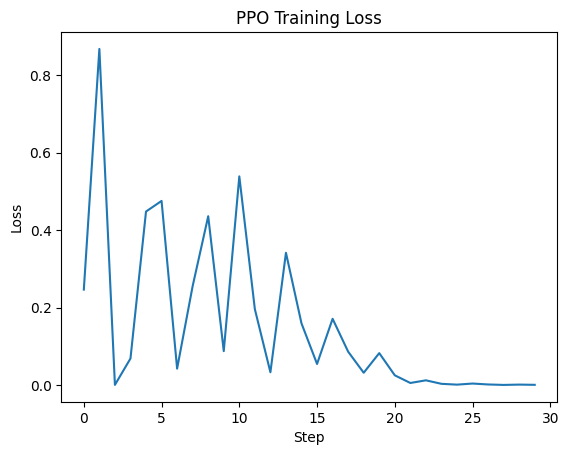

In [13]:
# Plot PPO losses
plt.plot(ppo_losses)
plt.title("PPO Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

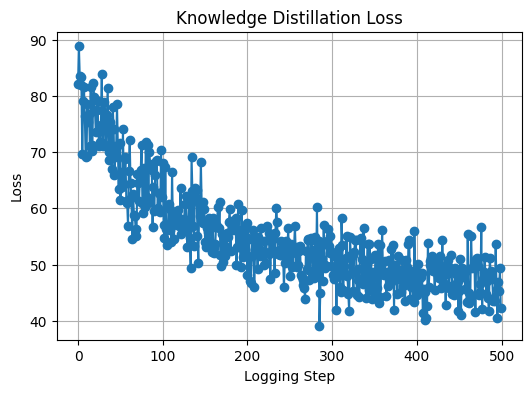

In [14]:
logs = trainer.state.log_history
loss_values = [entry["loss"] for entry in logs if "loss" in entry]
steps = range(len(loss_values))  # each log has an approximate step index

plt.figure(figsize=(6,4))
plt.plot(steps, loss_values, marker="o")
plt.title("Knowledge Distillation Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()